In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon
import seaborn as sns
import arviz as az
from os import listdir, makedirs
import pickle

In [4]:
# Data location
PROJECT_PATH = '/Users/euanprentis/Documents/feat_predict_simulations/exp-1'
DATA_PATH = f'{PROJECT_PATH}/data'
RESULTS_PATH = f'{PROJECT_PATH}/results'
TRANSITION_RESULTS_DIR = 'transition-influence/training'
FIG_PATH = f'{PROJECT_PATH}/figs'

# Model info
MODELS = [
    'model-ff_edim-2_sdim-1_depth-1',
    'model-ff_edim-2_sdim-1_depth-2',
    'model-ff_edim-2_sdim-1_depth-3',
    'model-ff_edim-2_sdim-1_depth-4',
    'model-ff_edim-2_sdim-2_depth-1',
    'model-ff_edim-2_sdim-2_depth-2',
    'model-ff_edim-2_sdim-2_depth-3',
    'model-ff_edim-2_sdim-2_depth-4',
    'model-ff_edim-3_sdim-1_depth-1',
    'model-ff_edim-3_sdim-1_depth-2',
    'model-ff_edim-3_sdim-1_depth-3',
    'model-ff_edim-3_sdim-1_depth-4',
    'model-ff_edim-3_sdim-2_depth-1',
    'model-ff_edim-3_sdim-2_depth-2',
    'model-ff_edim-3_sdim-2_depth-3',
    'model-ff_edim-3_sdim-2_depth-4',
    'model-ff_edim-4_sdim-1_depth-1',
    'model-ff_edim-4_sdim-1_depth-2',
    'model-ff_edim-4_sdim-1_depth-3',
    'model-ff_edim-4_sdim-1_depth-4',
    'model-ff_edim-4_sdim-2_depth-1',
    'model-ff_edim-4_sdim-2_depth-2',
    'model-ff_edim-4_sdim-2_depth-3',
    'model-ff_edim-4_sdim-2_depth-4',
]
N_PARAM_BINS = 5

TRANSITION_INFLUENCE_COLORS = {
    'incidental': '#F52342',
    'true': '#FFBC42'
}

In [5]:
# Mkae figure path if it does not exist
makedirs(FIG_PATH, exist_ok=True)

# Functions

## Helper Functions

In [6]:
def load_data_from_dir(dpath):
    """
    Load data from a directory into a single pandas DataFrame
    
    Arguments
    ---------
    dpath : str
        path to data directory
        
    Returns
    -------
    data : pd.DataFrame
        phase data
    """
    data = []
    for f in listdir(dpath):
        if f.startswith('.'):
            continue
        data.append(pd.read_csv(f'{dpath}/{f}'))
    data = pd.concat(data)
    return data

def information_from_label(model_label):
    """
    Get field information from model label

    Arguments
    ---------
    model_label : str
        model label
    
    Returns
    -------
    fields
    """
    fields = {}
    for field in model_label.split('_'):
        if not '-' in field:
            continue
        key, value = field.split('-')
        fields[key] = value
    return fields

def convert_states_to_labels(states):
    """
    Convert array of states to string labels

    Arguments
    ---------
    states : np.ndarray
        Array represent states by their features

    Returns
    -------
    labels : list
        state labels
    """
    labels = [''.join(label) for label in states.astype(str)]
    return labels

def standardize_reps_order(reps):
    """
    Standardize the order of representations

    Arguments
    ---------
    reps : dict
        representation dictionary

    Returns
    -------
    reps : dict
        standardized representation dictionary
    """
    
    # Get indices for standardized ordering
    idx_sorted_S = np.lexsort(reps['S'].T[::-1])
    idx_sorted_F = np.lexsort(reps['F_raw'].T[::-1])
    S = reps['S'][idx_sorted_S]
    F_raw = reps['F_raw'][idx_sorted_F]

    # Re-order rows by whether starts are conjunctive or not
    if reps['agent_info']['conjunctive_starts']:
        M = reps['M'][idx_sorted_S]
        bias = reps['bias'][idx_sorted_S]
        row_labels = convert_states_to_labels(S)
    else:
        M = reps['M'][idx_sorted_F]
        bias = reps['bias'][idx_sorted_F]
        row_labels = convert_states_to_labels(F_raw)

    # Re-order columns by whether successors are conjunctive or not
    if reps['agent_info']['conjunctive_successors']:
        M = M.T[idx_sorted_S].T
        bias = bias.T[idx_sorted_S].T
        col_labels = convert_states_to_labels(S)
    else:
        M = M.T[idx_sorted_F].T
        bias = bias.T[idx_sorted_F].T
        col_labels = convert_states_to_labels(F_raw)

    # Assign re-ordered representations
    reps['S'] = S
    reps['F_raw'] = F_raw
    reps['M'] = M
    reps['bias'] = bias
    reps['row_labels'] = row_labels
    reps['col_labels'] = col_labels

    return reps

def set_axis_ratio(ax, ratio=1):
    """
    Make axis aspect ratio square
    
    Arguments
    ---------
    ax : matplotlib.Axes
        matplotlib axis to transform
    ratio : int or float
        ratio of y- to x-axis
        
    Returns
    -------
    None
    """
    ax.set_aspect(ratio/ax.get_data_ratio(), adjustable='box')

def round_interval_labels(interval_series, n):
    """
    Round interval labels to n decimal places

    Arguments
    ---------
    interval_series : pd.Series
        series of pandas Interval objects
    
    Returns
    -------
    interval_series : pd.Series
        series of pandas Interval objects with rounded labels
    """
    return interval_series.apply(
        lambda x: pd.Interval(
            np.abs(round(x.left, n)),
            np.abs(round(x.right, n))
        )
    )

def bin_params(params, n_bins, method=pd.cut):
    """
    Bin parameters into n_bins

    Arguments
    ---------
    params : np.ndarray
        parameter values
    n_bins : int
        number of bins
    
    Returns
    -------
    params_binned : np.ndarray
        binned parameter values
    """
    params_binned = method(params, n_bins)
    params_binned = round_interval_labels(params_binned, 2)
    return params_binned

## Plot Functions

In [7]:
def plot_training_curve(
        df,
        y,
        grouping_var,
        palette = 'rocket',
        title = None,
        legend_title = None):
    """
    Plot training curve

    Arguments
    ---------
    df : pd.DataFrame
        training data
    y : str
        variable to plot on y-axis ('reward' or 'p')
    grouping_var : str
        variable to group by
    palette : list
        color palette
    title : str
        title for plot
    legend_title : str
        title for legend
    
    Returns
    -------
    None
    """
    fig, ax = plt.subplots(figsize=(6, 3))
    blocks = df['block'].unique()
    if len(blocks) > 1:
        ax.axvline(np.max(df['trial'])/len(blocks), color='black')
    for block in blocks:
        idx = df['block'] == block
        sns.lineplot(
            data = df.loc[idx],
            x = 'trial',
            y = y,
            hue = grouping_var,
            palette = palette,
            ci = None
        )
    n_labels = len(df[grouping_var].unique())
    handles, labels = plt.gca().get_legend_handles_labels()
    ax.legend(
        handles[-n_labels:],
        labels[-n_labels:],
        title = legend_title,
        loc = (1.05, .45)
    )
    ax.set_xlabel('Trial')
    if y == 'reward':
        max_reward = np.max(df['reward'])
        ax.axhline(max_reward/2, color='black', linestyle='--', zorder=0)
        ax.set_ylabel('Reward')
        ax.set_ylim(None, max_reward)
    elif y == 'p':
        ax.axhline(.25, color='black', linestyle='--', zorder=0)
        ax.set_ylabel('P(Choice)')
        ax.set_ylim(0, 1)
    elif y == 'resid':
        ax.axhline(.72, color='black', linestyle='--', zorder=0)
        ax.set_ylabel('Residual')
        ax.set_ylim(0, 1)
    ax.set_title(title, loc='left')

def plot_param_interaction(
        df,
        continous_param,
        binned_param,
        y,
        title = None,
        legend_title = None,
        xlabel = None,
        ylabel = None,
        palette = 'rocket'
):
    
    # Get average reward by alpha and segmentation bin
    plot_df = df[['id', continous_param, binned_param, y]]
    plot_df = plot_df.groupby(['id', continous_param, binned_param])
    plot_df = plot_df.mean().reset_index()

    # Y-intercept of chance line
    if y == 'reward':
        max_reward = np.max(df['reward'])
        chance = max_reward/2
    elif y == 'p':
        chance = .25
    elif y == 'coef':
        chance = 0
    
    # Plot
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.axhline(chance, color='black', linestyle='--', zorder=0)
    n_bins = len(plot_df[binned_param].unique())
    for i, param_bin in enumerate(plot_df[binned_param].unique()):
        idx = plot_df[binned_param] == param_bin
        sns.regplot(
            data = plot_df.loc[idx],
            x = continous_param,
            y = y,
            scatter = False,
            color = sns.color_palette(palette, n_bins)[i],
            label = param_bin
        )
    ax.legend(title=legend_title, loc=(1.05, .45))
    if y == 'reward':
        ax.set_ylim(None, max_reward)
    elif y == 'p':
        ax.set_ylim(0, 1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title, loc='left')
    set_axis_ratio(ax)

# Load Data

## Training

In [8]:
# Load training data
training_df = []
for model in MODELS:
    model_df = load_data_from_dir(f'{DATA_PATH}/{model}/training')
    model_info = information_from_label(model)
    for key, value in model_info.items():
        model_df[key] = value
    training_df.append(model_df)
training_df = pd.concat(training_df)
training_df = training_df.reset_index(drop=True)
training_df['block'] = 1
training_df

,id,model_label,alpha,alpha_decay,beta,beta_test,gamma,segmentation,inference_inhibition,conjunctive_starts,...,composition,successor,p,reward,correct,model,edim,sdim,depth,block
0,161,model-ff_edim-2_sdim-1_depth-1,0.508661,0,2.882154,2.882154,1,0,1.257135,False,...,[2 0],[1 0],0.500000,1,1,ff,2,1,1,1
1,161,model-ff_edim-2_sdim-1_depth-1,0.508661,0,2.882154,2.882154,1,0,1.257135,False,...,[3 0],[4 0],0.500000,1,1,ff,2,1,1,1
2,161,model-ff_edim-2_sdim-1_depth-1,0.508661,0,2.882154,2.882154,1,0,1.257135,False,...,[3 0],[4 0],0.500000,1,1,ff,2,1,1,1
3,161,model-ff_edim-2_sdim-1_depth-1,0.508661,0,2.882154,2.882154,1,0,1.257135,False,...,[3 0],[4 0],0.500000,0,0,ff,2,1,1,1
4,161,model-ff_edim-2_sdim-1_depth-1,0.508661,0,2.882154,2.882154,1,0,1.257135,False,...,[3 0],[4 0],0.500000,0,0,ff,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319995,187,model-ff_edim-4_sdim-2_depth-4,0.185657,0,0.005949,0.005949,1,0,1.365930,False,...,[0 6 0 6],[ 0 10 0 10],0.253908,2,1,ff,4,2,4,1
2319996,187,model-ff_edim-4_sdim-2_depth-4,0.185657,0,0.005949,0.005949,1,0,1.365930,False,...,[0 5 0 6],[ 0 1 0 10],0.249211,1,0,ff,4,2,4,1
2319997,187,model-ff_edim-4_sdim-2_depth-4,0.185657,0,0.005949,0.005949,1,0,1.365930,False,...,[6 0 6 0],[10 0 10 0],0.254234,2,1,ff,4,2,4,1
2319998,187,model-ff_edim-4_sdim-2_depth-4,0.185657,0,0.005949,0.005949,1,0,1.365930,False,...,[6 5 0 0],[10 1 0 0],0.249787,1,0,ff,4,2,4,1


## Test

In [9]:
test_df = []
for model in MODELS:
    model_df = load_data_from_dir(f'{DATA_PATH}/{model}/test')
    model_info = information_from_label(model)
    for key, value in model_info.items():
        model_df[key] = value
    test_df.append(model_df)
test_df = pd.concat(test_df)
test_df = test_df.reset_index(drop=True)
test_df

,id,model_label,alpha,alpha_decay,beta,beta_test,gamma,segmentation,inference_inhibition,conjunctive_starts,...,options,composition,successor,p,reward,correct,model,edim,sdim,depth
0,150,model-ff_edim-2_sdim-1_depth-1,0.368180,0,0.158994,0.158994,1,0,3.841646,False,...,[[[2 0]\n [3 0]]],[2 0],[1 0],0.500000,0,0,ff,2,1,1
1,150,model-ff_edim-2_sdim-1_depth-1,0.368180,0,0.158994,0.158994,1,0,3.841646,False,...,[[[2 0]\n [3 0]]],[2 0],[1 0],0.500000,0,0,ff,2,1,1
2,150,model-ff_edim-2_sdim-1_depth-1,0.368180,0,0.158994,0.158994,1,0,3.841646,False,...,[[[2 0]\n [3 0]]],[2 0],[1 0],0.939983,1,1,ff,2,1,1
3,150,model-ff_edim-2_sdim-1_depth-1,0.368180,0,0.158994,0.158994,1,0,3.841646,False,...,[[[2 0]\n [3 0]]],[3 0],[4 0],0.873424,1,1,ff,2,1,1
4,150,model-ff_edim-2_sdim-1_depth-1,0.368180,0,0.158994,0.158994,1,0,3.841646,False,...,[[[0 2]\n [0 3]]],[0 2],[0 1],0.921183,1,1,ff,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241995,149,model-ff_edim-4_sdim-2_depth-4,0.788873,0,0.596984,0.596984,1,0,1.027141,False,...,[[[0 0 5 0]\n [0 0 6 0]]\n\n [[0 0 0 5]\n [0...,[0 0 6 5],[ 0 0 10 1],1.000000,1,0,ff,4,2,4
241996,149,model-ff_edim-4_sdim-2_depth-4,0.788873,0,0.596984,0.596984,1,0,1.027141,False,...,[[[0 0 5 0]\n [0 0 6 0]]\n\n [[0 0 0 5]\n [0...,[0 0 6 5],[ 0 0 10 1],0.999963,0,0,ff,4,2,4
241997,149,model-ff_edim-4_sdim-2_depth-4,0.788873,0,0.596984,0.596984,1,0,1.027141,False,...,[[[0 0 5 0]\n [0 0 6 0]]\n\n [[0 0 0 5]\n [0...,[0 0 5 6],[ 0 0 1 10],1.000000,0,0,ff,4,2,4
241998,149,model-ff_edim-4_sdim-2_depth-4,0.788873,0,0.596984,0.596984,1,0,1.027141,False,...,[[[0 0 5 0]\n [0 0 6 0]]\n\n [[0 0 0 5]\n [0...,[0 0 6 5],[ 0 0 10 1],1.000000,0,0,ff,4,2,4


## Representations

In [10]:
representations = {}
for model in MODELS:
    model_info = information_from_label(model)
    for fname in listdir(f'{DATA_PATH}/{model}/representations'):
        if fname.startswith('.'):
            continue
        agent_id = int(fname.split('_')[1].replace('.pkl', ''))
        with open(f'{DATA_PATH}/{model}/representations/{fname}', 'rb') as f:
            representations[model, agent_id] = standardize_reps_order(
                pickle.load(f)
            )
            for key, value in model_info.items():
                representations[model, agent_id][key] = value

## Subject Information 

In [11]:
subj_df = test_df[[
    'id',
    'model_label',
    'edim',
    'sdim',
    'depth',
    'alpha',
    'beta',
    'gamma'
]]
subj_df = subj_df.drop_duplicates()
subj_df = subj_df.reset_index(drop=True)

# Bin parameters and add to choice data
subj_df['gamma_binned'] = bin_params(
    subj_df['gamma'],
    N_PARAM_BINS
)

training_df = pd.merge(
    training_df,
    subj_df[['id', 'gamma_binned']],
    on = 'id'
)

subj_df

,id,model_label,edim,sdim,depth,alpha,beta,gamma,gamma_binned
0,150,model-ff_edim-2_sdim-1_depth-1,2,1,1,0.368180,0.158994,1,"(1.0, 1.0]"
1,144,model-ff_edim-2_sdim-1_depth-1,2,1,1,0.493794,1.166861,1,"(1.0, 1.0]"
2,178,model-ff_edim-2_sdim-1_depth-1,2,1,1,0.737182,0.507651,1,"(1.0, 1.0]"
3,193,model-ff_edim-2_sdim-1_depth-1,2,1,1,0.922488,3.845946,1,"(1.0, 1.0]"
4,187,model-ff_edim-2_sdim-1_depth-1,2,1,1,0.185657,0.005949,1,"(1.0, 1.0]"
...,...,...,...,...,...,...,...,...,...
5995,203,model-ff_edim-4_sdim-2_depth-4,4,2,4,0.261764,0.601075,1,"(1.0, 1.0]"
5996,12,model-ff_edim-4_sdim-2_depth-4,4,2,4,0.770847,29.420525,1,"(1.0, 1.0]"
5997,161,model-ff_edim-4_sdim-2_depth-4,4,2,4,0.508661,2.882154,1,"(1.0, 1.0]"
5998,175,model-ff_edim-4_sdim-2_depth-4,4,2,4,0.739558,3.207027,1,"(1.0, 1.0]"


## Transition Influence

### Results

In [12]:
trans_influence_df = []
for group_label in listdir(RESULTS_PATH):
    if group_label.startswith('.'):
        continue
    this_path = f'{RESULTS_PATH}/{group_label}/transition-influence/training/agent'
    for fname in listdir(this_path):
        if fname.startswith('.'):
            continue
        
        # Get agent ID from file name
        agent_id = int(fname.replace('.pkl', '').split('_')[1])

        # Load trace
        with open(f'{this_path}/{fname}', 'rb') as f:
            trace = pickle.load(f)

        # Extract coefficients
        coefs = az.summary(trace)['mean'].values
        n_actions = int(len(coefs)/2)
        coefs = coefs.reshape(-1, 2)
        
        # Add to full results set
        try:
            coefs_df = pd.DataFrame({
                'model_label': group_label,
                'id': agent_id,
                'action': np.arange(1, n_actions + 1),
                'incidental': coefs[:, 0],
                'true': coefs[:, 1]
            })

        except:
            print('Error with agent:', agent_id)
            continue


        trans_influence_df.append(coefs_df)

trans_influence_df = pd.concat(trans_influence_df)
trans_influence_df = trans_influence_df.reset_index(drop=True)

# Convert to long
trans_influence_df = pd.melt(
    trans_influence_df,
    id_vars = ['model_label', 'id', 'action'],
    value_vars = ['incidental', 'true'],
    var_name = 'transition',
    value_name = 'coef'
)
trans_influence_df = trans_influence_df.reset_index(drop=True)

# Add parameter information
trans_influence_df = pd.merge(
    trans_influence_df,
    subj_df,
    on = ['model_label', 'id']
)

trans_influence_df

,model_label,id,action,transition,coef,edim,sdim,depth,alpha,beta,gamma,gamma_binned
0,model-ff_edim-3_sdim-2_depth-1,228,1,incidental,2.021,3,2,1,0.457787,1.489463,1,"(1.0, 1.0]"
1,model-ff_edim-3_sdim-2_depth-1,228,2,incidental,0.694,3,2,1,0.457787,1.489463,1,"(1.0, 1.0]"
2,model-ff_edim-3_sdim-2_depth-1,228,3,incidental,1.834,3,2,1,0.457787,1.489463,1,"(1.0, 1.0]"
3,model-ff_edim-3_sdim-2_depth-1,214,1,incidental,1.818,3,2,1,0.841680,0.028978,1,"(1.0, 1.0]"
4,model-ff_edim-3_sdim-2_depth-1,214,2,incidental,1.103,3,2,1,0.841680,0.028978,1,"(1.0, 1.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...
17777,model-ff_edim-2_sdim-2_depth-2,225,2,true,2.444,2,2,2,0.849889,0.508034,1,"(1.0, 1.0]"
17778,model-ff_edim-2_sdim-2_depth-2,225,3,true,2.300,2,2,2,0.849889,0.508034,1,"(1.0, 1.0]"
17779,model-ff_edim-2_sdim-2_depth-2,231,1,true,7.950,2,2,2,0.765247,14.825493,1,"(1.0, 1.0]"
17780,model-ff_edim-2_sdim-2_depth-2,231,2,true,4.696,2,2,2,0.765247,14.825493,1,"(1.0, 1.0]"


In [13]:
trans_influence_trial_df = []
for group_label in listdir(RESULTS_PATH):
    if group_label.startswith('.'):
        continue
    this_path = f'{RESULTS_PATH}/{group_label}/transition-influence/training/trial'
    for fname in listdir(this_path):
        if fname.startswith('.'):
            continue
        
        # Get agent ID from file name
        trial = int(fname.replace('.pkl', '').split('_')[1])

        # Load trace
        with open(f'{this_path}/{fname}', 'rb') as f:
            trace = pickle.load(f)

        # Extract coefficients
        coefs = az.summary(trace)['mean'].values
        n_actions = int(len(coefs)/2)
        coefs = coefs.reshape(-1, 2)
        
        # Add to full results set
        try:
            coefs_df = pd.DataFrame({
                'model_label': group_label,
                'trial': trial,
                'action': np.arange(1, n_actions + 1),
                'incidental': coefs[:, 0],
                'true': coefs[:, 1]
            })

        except:
            print('Error with agent:', agent_id)
            continue


        trans_influence_trial_df.append(coefs_df)

trans_influence_trial_df = pd.concat(trans_influence_trial_df)
trans_influence_trial_df = trans_influence_trial_df.reset_index(drop=True)

# Convert to long
trans_influence_trial_df = pd.melt(
    trans_influence_trial_df,
    id_vars = ['model_label', 'trial', 'action'],
    value_vars = ['incidental', 'true'],
    var_name = 'transition',
    value_name = 'coef'
)
trans_influence_trial_df = trans_influence_trial_df.reset_index(drop=True)

# Add parameter information
trans_influence_trial_df = pd.merge(
    trans_influence_trial_df,
    subj_df[['model_label', 'sdim', 'edim', 'depth']].drop_duplicates(),
    on = ['model_label']
)

trans_influence_trial_df

,model_label,trial,action,transition,coef,sdim,edim,depth
0,model-ff_edim-3_sdim-2_depth-1,214,1,incidental,1.102,2,3,1
1,model-ff_edim-3_sdim-2_depth-1,214,2,incidental,1.943,2,3,1
2,model-ff_edim-3_sdim-2_depth-1,214,3,incidental,2.291,2,3,1
3,model-ff_edim-3_sdim-2_depth-1,374,1,incidental,2.156,2,3,1
4,model-ff_edim-3_sdim-2_depth-1,374,2,incidental,0.819,2,3,1
...,...,...,...,...,...,...,...,...
6691,model-ff_edim-2_sdim-2_depth-2,68,2,true,2.746,2,2,2
6692,model-ff_edim-2_sdim-2_depth-2,68,3,true,2.243,2,2,2
6693,model-ff_edim-2_sdim-2_depth-2,40,1,true,2.180,2,2,2
6694,model-ff_edim-2_sdim-2_depth-2,40,2,true,1.183,2,2,2


### Plot successor representations learned for agent = 1

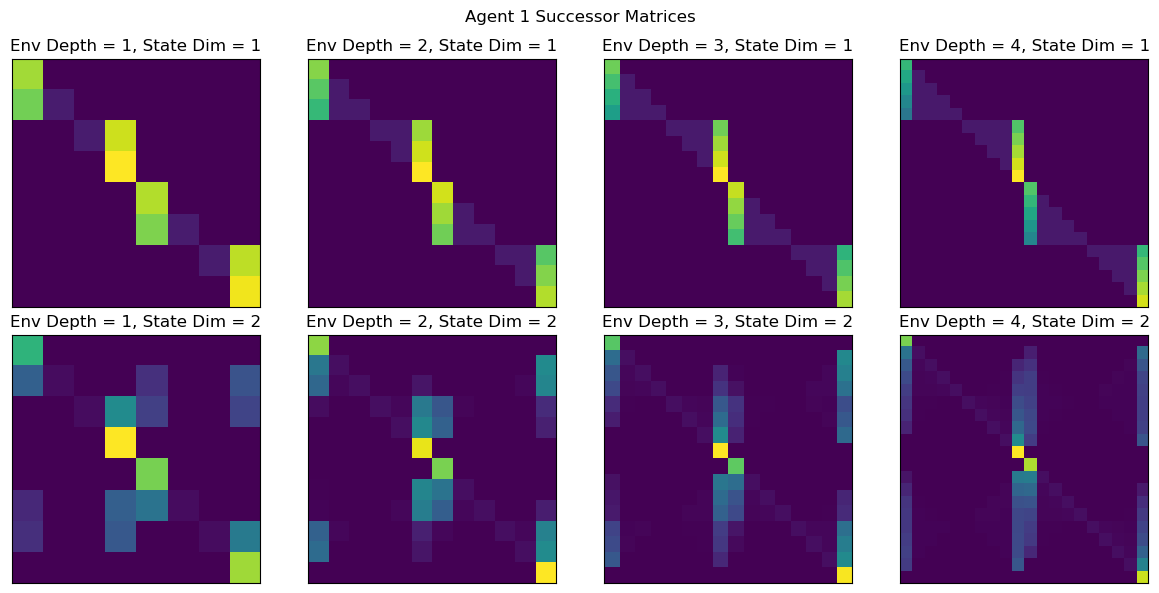

In [38]:
env_dim = 2
agent_id = 1

edim_models = [
    model_label for model_label in MODELS
    if f'edim-{env_dim}' in model_label

]
n_subplots = len(edim_models)
n_rows = 2
n_cols = int(np.ceil(n_subplots/n_rows))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))
for i, model in enumerate(edim_models):
    ax = axs[i//n_cols, i%n_cols]
    ax.imshow(representations[model, agent_id]['M'])
    depth = representations[model, agent_id]['depth']
    sdim = representations[model, agent_id]['sdim']
    ax.set_title(f'Env Depth = {depth}, State Dim = {sdim}')
    ax.set_xticks([])
    ax.set_yticks([])
fig.suptitle(f'Agent {agent_id} Successor Matrices')
fig.tight_layout()

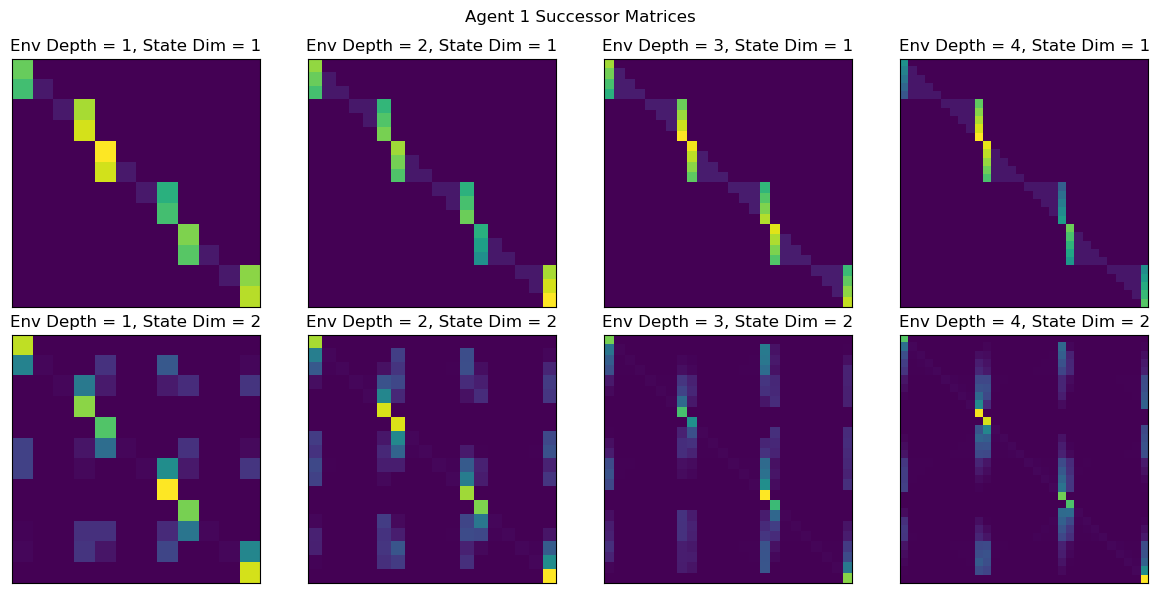

In [39]:
env_dim = 3
agent_id = 1

edim_models = [
    model_label for model_label in MODELS
    if f'edim-{env_dim}' in model_label

]
n_subplots = len(edim_models)
n_rows = 2
n_cols = int(np.ceil(n_subplots/n_rows))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))
for i, model in enumerate(edim_models):
    ax = axs[i//n_cols, i%n_cols]
    ax.imshow(representations[model, agent_id]['M'])
    depth = representations[model, agent_id]['depth']
    sdim = representations[model, agent_id]['sdim']
    ax.set_title(f'Env Depth = {depth}, State Dim = {sdim}')
    ax.set_xticks([])
    ax.set_yticks([])
fig.suptitle(f'Agent {agent_id} Successor Matrices')
fig.tight_layout()

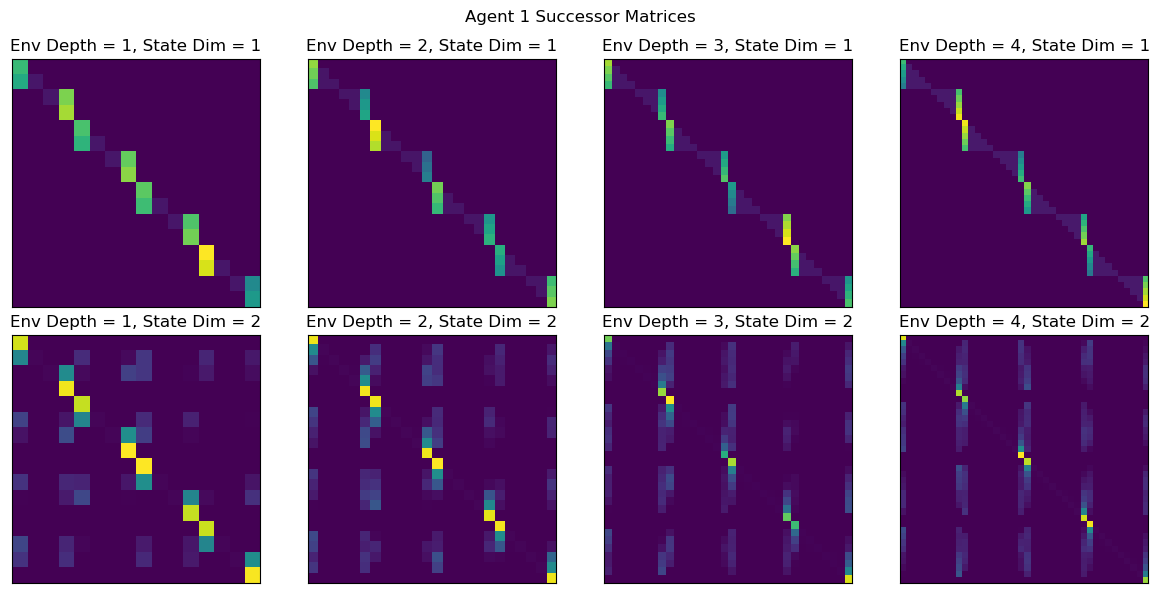

In [40]:
env_dim = 4
agent_id = 1

edim_models = [
    model_label for model_label in MODELS
    if f'edim-{env_dim}' in model_label

]
n_subplots = len(edim_models)
n_rows = 2
n_cols = int(np.ceil(n_subplots/n_rows))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))
for i, model in enumerate(edim_models):
    ax = axs[i//n_cols, i%n_cols]
    ax.imshow(representations[model, agent_id]['M'])
    depth = representations[model, agent_id]['depth']
    sdim = representations[model, agent_id]['sdim']
    ax.set_title(f'Env Depth = {depth}, State Dim = {sdim}')
    ax.set_xticks([])
    ax.set_yticks([])
fig.suptitle(f'Agent {agent_id} Successor Matrices')
fig.tight_layout()

## Plot weight of incidental versus true information in successor matrices

### Get incidental vs true information weight

In [29]:
def get_M_masks(key, representations):
     feats = []
     for lab in representations[key]['row_labels']:
          if len(lab) == (int(representations[key]['edim']) + 1):
              lab = lab.replace('10', 'a')
          feats.append([i != '0' for i in lab])
     feats = np.array(feats)
     true_mask = feats@feats.T
     incidental_mask = np.logical_not(true_mask)
     np.fill_diagonal(true_mask, False)
     return true_mask, incidental_mask

In [39]:
# Get incidental weights for each model and agent
incidental_weights = []
n_agents = int(len(representations)/len(MODELS))
for model in MODELS:
    for i in range(1, n_agents + 1):

        try:

            # Get within- (true) and between-feature (incidental) masks
            true_mask, incidental_mask = get_M_masks((model, i), representations)

            # Sum information in true vs incidental regions of M
            M = representations[model, i]['M']
            true_sum = np.sum(M[true_mask])
            incidental_sum = np.sum(M[incidental_mask])
            true_max = np.max(M[true_mask])
            incidental_max = np.max(M[incidental_mask])

            # Get ratio of incidental to true information
            incidental_weight = incidental_sum/(true_sum + incidental_sum)
            incidental_max_weight = incidental_max/(true_max + incidental_max)

            # Add to DataFrame
            incidental_weights.append({
                'id': i,
                'model_label': model,
                'edim': representations[model, i]['edim'],
                'sdim': representations[model, i]['sdim'],
                'depth': representations[model, i]['depth'],
                'incidental_weight': incidental_weight,
                'incidental_max_weight': incidental_max_weight
            })

        except:
            continue

# Convert to data frame
incidental_weights_df = pd.DataFrame(incidental_weights)

# Add discount information
incidental_weights_df = pd.merge(
    incidental_weights_df,
    subj_df[['id', 'gamma', 'gamma_binned']],
    on = 'id'
)
incidental_weights_df

,id,model_label,edim,sdim,depth,incidental_weight,incidental_max_weight,gamma,gamma_binned
0,1,model-ff_edim-2_sdim-1_depth-1,2,1,1,0.000000,0.000000,1,"(1.0, 1.0]"
1,1,model-ff_edim-2_sdim-1_depth-1,2,1,1,0.000000,0.000000,1,"(1.0, 1.0]"
2,1,model-ff_edim-2_sdim-1_depth-1,2,1,1,0.000000,0.000000,1,"(1.0, 1.0]"
3,1,model-ff_edim-2_sdim-1_depth-1,2,1,1,0.000000,0.000000,1,"(1.0, 1.0]"
4,1,model-ff_edim-2_sdim-1_depth-1,2,1,1,0.000000,0.000000,1,"(1.0, 1.0]"
...,...,...,...,...,...,...,...,...,...
143995,250,model-ff_edim-4_sdim-2_depth-4,4,2,4,0.649592,0.335443,1,"(1.0, 1.0]"
143996,250,model-ff_edim-4_sdim-2_depth-4,4,2,4,0.649592,0.335443,1,"(1.0, 1.0]"
143997,250,model-ff_edim-4_sdim-2_depth-4,4,2,4,0.649592,0.335443,1,"(1.0, 1.0]"
143998,250,model-ff_edim-4_sdim-2_depth-4,4,2,4,0.649592,0.335443,1,"(1.0, 1.0]"


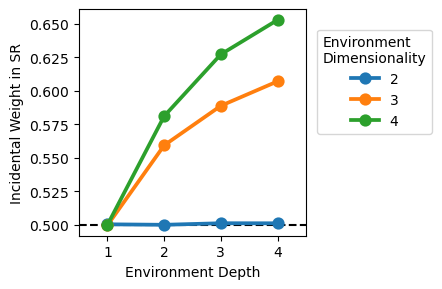

In [46]:
idx = incidental_weights_df['sdim'] == '2'
fig, ax = plt.subplots(figsize=(4, 3))
ax.axhline(.5, color='black', linestyle='--', zorder=0)
sns.pointplot(
    data = incidental_weights_df.loc[idx],
    x = 'depth',
    y = 'incidental_weight',
    hue = 'edim',
    ax = ax
)
ax.legend(title='Environment\nDimensionality', loc=(1.05, .45))
ax.set_xlabel('Environment Depth')
ax.set_ylabel('Incidental Weight in SR')
set_axis_ratio(ax)
fig.tight_layout()

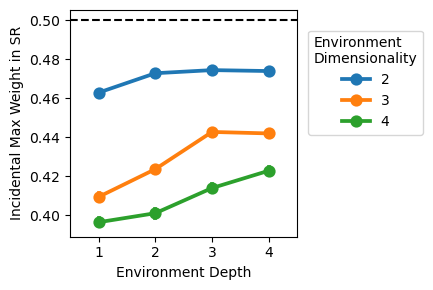

In [41]:
idx = incidental_weights_df['sdim'] == '2'
fig, ax = plt.subplots(figsize=(4, 3))
ax.axhline(.5, color='black', linestyle='--', zorder=0)
sns.pointplot(
    data = incidental_weights_df.loc[idx],
    x = 'depth',
    y = 'incidental_max_weight',
    hue = 'edim',
    ax = ax
)
ax.legend(title='Environment\nDimensionality', loc=(1.05, .45))
ax.set_xlabel('Environment Depth')
ax.set_ylabel('Incidental Max Weight in SR')
set_axis_ratio(ax)
fig.tight_layout()

# Training Analysis

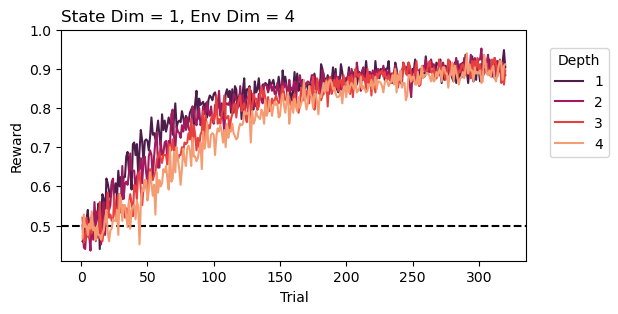

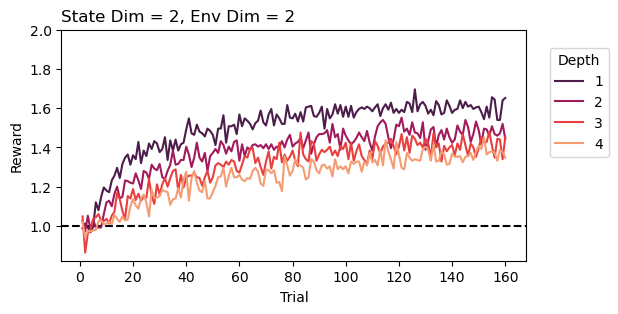

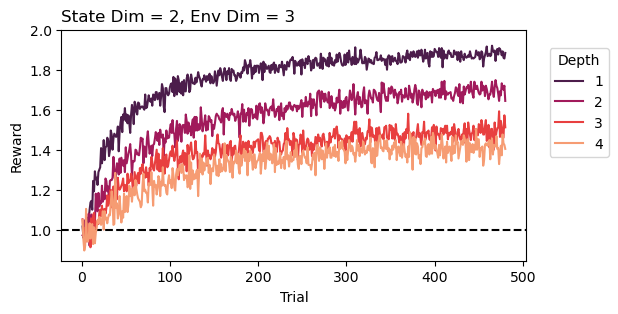

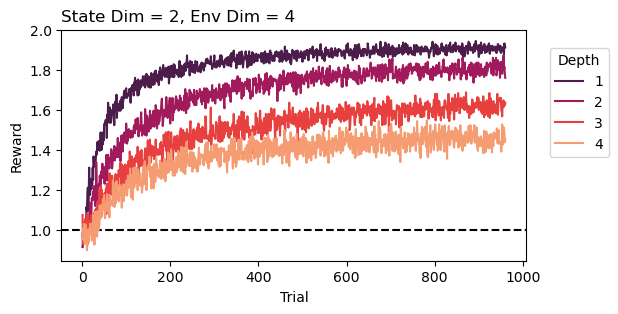

In [27]:
idx = (training_df['sdim'] == '1') & (training_df['edim'] == '4') 
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'depth',
    legend_title = 'Depth',
    title = 'State Dim = 1, Env Dim = 4',
)

idx = (training_df['sdim'] == '2') & (training_df['edim'] == '2') 
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'depth',
    legend_title = 'Depth',
    title = 'State Dim = 2, Env Dim = 2',
)

idx = (training_df['sdim'] == '2') & (training_df['edim'] == '3') 
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'depth',
    legend_title = 'Depth',
    title = 'State Dim = 2, Env Dim = 3',
)

idx = (training_df['sdim'] == '2') & (training_df['edim'] == '4') 
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'depth',
    legend_title = 'Depth',
    title = 'State Dim = 2, Env Dim = 4',
)

### Transition Influence

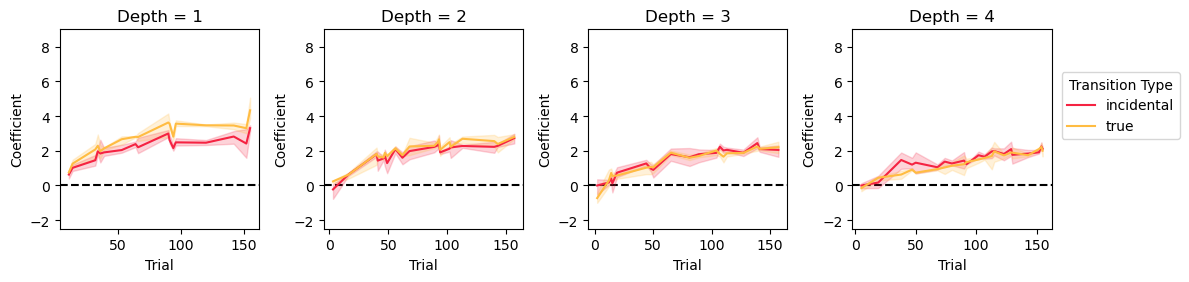

In [87]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i, depth in enumerate(['1', '2', '3', '4']):
    ax = axs[i]
    idx = (
        (trans_influence_trial_df['depth'] == depth) &
        (trans_influence_trial_df['edim'] == '2')
    )
    ax.axhline(0, color='black', linestyle='--', zorder=0)
    sns.lineplot(
        data = trans_influence_trial_df.loc[idx],
        x = 'trial',
        y = 'coef',
        hue = 'transition',
        palette = TRANSITION_INFLUENCE_COLORS,
        ax = ax
    )
    ax.set_ylim(-2.5, 9)
    ax.set_title(f'Depth = {depth}')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Coefficient')
    if i < 3:
        ax.get_legend().remove()
    set_axis_ratio(ax)
ax.legend(title='Transition Type', loc=(1.05, .45))
fig.tight_layout()

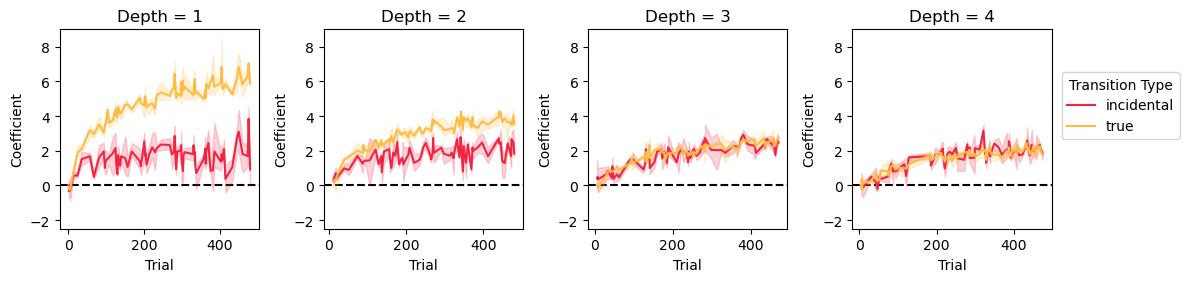

In [86]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i, depth in enumerate(['1', '2', '3', '4']):
    ax = axs[i]
    idx = (
        (trans_influence_trial_df['depth'] == depth) &
        (trans_influence_trial_df['edim'] == '3')
    )
    ax.axhline(0, color='black', linestyle='--', zorder=0)
    sns.lineplot(
        data = trans_influence_trial_df.loc[idx],
        x = 'trial',
        y = 'coef',
        hue = 'transition',
        palette = TRANSITION_INFLUENCE_COLORS,
        ax = ax
    )
    ax.set_ylim(-2.5, 9)
    ax.set_title(f'Depth = {depth}')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Coefficient')
    if i < 3:
        ax.get_legend().remove()
    set_axis_ratio(ax)
ax.legend(title='Transition Type', loc=(1.05, .45))
fig.tight_layout()

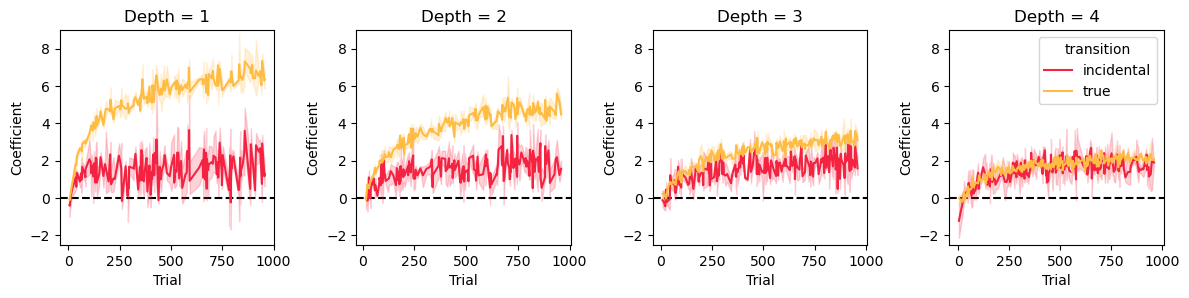

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i, depth in enumerate(['1', '2', '3', '4']):
    ax = axs[i]
    idx = (
        (trans_influence_trial_df['depth'] == depth) &
        (trans_influence_trial_df['edim'] == '4')
    )
    ax.axhline(0, color='black', linestyle='--', zorder=0)
    sns.lineplot(
        data = trans_influence_trial_df.loc[idx],
        x = 'trial',
        y = 'coef',
        hue = 'transition',
        palette = TRANSITION_INFLUENCE_COLORS,
        ax = ax
    )
    ax.set_ylim(-2.5, 9)
    ax.set_title(f'Depth = {depth}')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Coefficient')
    if i < 3:
        ax.get_legend().remove()
    set_axis_ratio(ax)
ax.legend(title='Transition Type', loc=(1.05, .45))
fig.tight_layout()

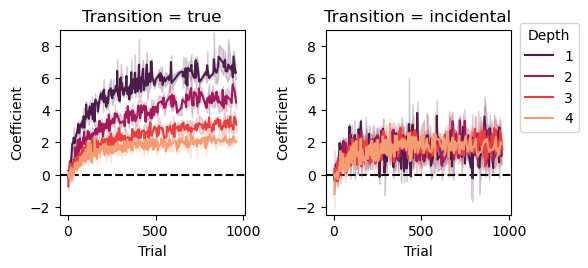

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
for i, transition in enumerate(['true', 'incidental']):
    ax = axs[i]
    idx = trans_influence_trial_df['transition'] == transition
    ax.axhline(0, color='black', linestyle='--', zorder=0)
    sns.lineplot(
        data = trans_influence_trial_df.loc[idx],
        x = 'trial',
        y = 'coef',
        hue = 'depth',
        palette = 'rocket',
        ax = ax
    )
    ax.set_ylim(-2.5, 9)
    ax.set_title(f'Transition = {transition}')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Coefficient')
    if i < 1:
        ax.get_legend().remove()
    set_axis_ratio(ax)
ax.legend(title='Depth', loc=(1.05, .45))
fig.tight_layout()

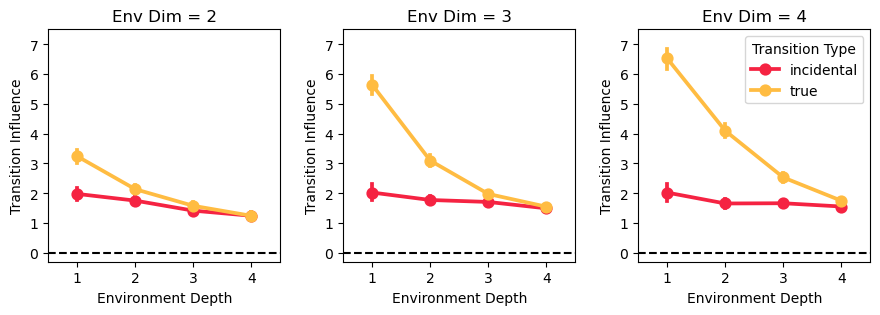

In [26]:
plot_df = trans_influence_df[['id', 'edim', 'depth', 'transition', 'coef']]
plot_df = plot_df.groupby(['id', 'edim', 'depth', 'transition'])
plot_df = plot_df.mean().reset_index()

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for i, edim in enumerate(['2', '3', '4']):
    ax = axs[i]
    idx = plot_df['edim'] == edim
    ax.axhline(0, color='black', linestyle='--', zorder=0)
    sns.pointplot(
        data = plot_df.loc[idx],
        x = 'depth',
        y = 'coef',
        hue = 'transition',
        palette = TRANSITION_INFLUENCE_COLORS,
        ax = ax
    )
    ax.set_ylim(-.3, 7.5)
    ax.set_title(f'Env Dim = {edim}')
    ax.set_xlabel('Environment Depth')
    ax.set_ylabel('Transition Influence')
    if i < 2:
        ax.get_legend().remove()
    set_axis_ratio(ax)
ax.legend(title='Transition Type')
fig.tight_layout()